# [Instagram Page Screen Shots in 5 Category](https://www.kaggle.com/datasets/bahramjannesarr/instagram-page-screen-shots-in-5-category)

## 1. Import Module

In [4]:
import numpy as np
import matplotlib.pyplot as plt # visualization
import random
import os
%matplotlib inline
import shutil
import zipfile

import torch
import torch.nn as nn # neural network
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.models as models
import torch.optim as optim

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
 os.getcwd()

'/content'

In [8]:
root = '/content/drive/MyDrive/yai_proj'

%cd /content/drive/MyDrive/yai_proj

/content/drive/MyDrive/yai_proj


In [12]:
os.getcwd()

'/content/drive/MyDrive/yai_proj'

In [10]:
try:
    from torchsummary import summary # 깔끔하게 pytorch 출력
    import splitfolders
except:
    !pip install torchsummary
    from torchsummary import summary
    !pip install split-folders tdqm  # progress bar도 함께 보여주기 위해 tdqm 같이 써줌
    import splitfolders

In [11]:
assets_path = os.path.join(os.getcwd(), 'assets')

if (os.path.isdir(assets_path) == False):
    os.mkdir(assets_path)
else:
    print('assets directory already exists')

In [13]:
# Save Figure
fig_path = './assets/'

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    #해상도 dpi=300
    path = fig_path + fig_name + "." + fig_extension
    print("Save Figure: ", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. DEVICE Setting

In [14]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(' PyTorch version : ', torch.__version__, '\n', 'Device : ', DEVICE)

# 난수 지정
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic = True 

 PyTorch version :  1.12.1+cu113 
 Device :  cuda


## 3. PARAMETER Setting

In [84]:
BATCH_SIZE = 64
EPOCHS = 20
TEST_RATIO = 0.2
learning_rate = 0.0001

## 4. Download Data From Kaggle

- Create New token
- move kaggle.json to ~\.kaggle\kaggle.json

In [17]:
# !pip install kaggle
!pip show kaggle

Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: certifi, python-dateutil, tqdm, urllib3, requests, six, python-slugify
Required-by: 


In [18]:
os.environ['KAGGLE_USERNAME'] = 'kkkkkkkiii' # your-kaggle-username
os.environ['KAGGLE_KEY'] = 'adf7a4ef846bfd6a1b21002d7b3d0b5a' # your-kaggle-api-key

In [19]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [20]:
api.dataset_download_files('bahramjannesarr/instagram-page-screen-shots-in-5-category', path="./dataset")

In [21]:
root = os.getcwd()
dataset_dir = os.path.join(root, 'dataset')

zipfile_name = os.listdir(dataset_dir)[0]
zipfile_name

'instagram-page-screen-shots-in-5-category.zip'

In [22]:
zipfile_path = os.path.join(dataset_dir, zipfile_name)

zipfile.ZipFile(zipfile_path).extractall(path='./dataset/')

In [23]:
os.listdir(dataset_dir)

['instagram-page-screen-shots-in-5-category.zip',
 'beauty',
 'family',
 'fashion',
 'fitness',
 'food']

In [24]:
splitfolders.ratio(dataset_dir, output='./split_dataset', seed=1, ratio=(1-TEST_RATIO, TEST_RATIO))

Copying files: 3770 files [00:37, 99.24 files/s] 


In [25]:
train_dataset_dir = os.path.join(root, 'split_dataset', 'train')
test_dataset_dir = os.path.join(root, 'split_dataset', 'val')

In [26]:
train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=transforms.ToTensor())

# train_dataset_size = int(TEST_RATIO * len(dataset))
# test_dataset_size = len(dataset) - train_dataset_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_size, test_dataset_size])

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_dataset:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_dataset)
stds /= len(train_dataset)
    
print(f'Means: {means}')
print(f'STDs: {stds}')

Means: tensor([0.6395, 0.5844, 0.5506])
STDs: tensor([0.2851, 0.2930, 0.3085])


In [27]:
img_size = 224
trained_means = [0.6395, 0.5844, 0.5506]
trained_stds= [0.2851, 0.2930, 0.3085]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size), # image를 (224, 224) 사이즈로 변경하되, 변경되는 image pixel 값은 random으로 선택
    # segementatin에 많이 사용됨. translation 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=trained_means, std=trained_stds) 
    # ToTensor()형태로 전환된 image에 대해 또 다른 Normalization을 진행 (mean, std 필요한데 R, G, B 순으로 mean, std Normalization 적용)
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=trained_means, std=trained_stds) 
])  # test는 augmentation을 하면 안됨. (resize, 정규화)

dataset = datasets.ImageFolder(root=dataset_dir, transform=transforms.ToTensor())

train_dataset = datasets.ImageFolder(root=train_dataset_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dataset_dir, transform=test_transforms)
num_of_classes = len(dataset.classes)

print('Classes : ', dataset.classes)
print('Num of Classes : ', num_of_classes)
print('Total Data Size : ', len(dataset))
print('Train Data Size : ', len(train_dataset))
print('Test Data Size : ', len(test_dataset))

Classes :  ['beauty', 'family', 'fashion', 'fitness', 'food']
Num of Classes :  5
Total Data Size :  3770
Train Data Size :  3015
Test Data Size :  755


## 5. Check Imbalanced Classification

In [28]:
# class idx 확인
dataset.class_to_idx

{'beauty': 0, 'family': 1, 'fashion': 2, 'fitness': 3, 'food': 4}

In [29]:
# reverse (mapping idx to class)
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{0: 'beauty', 1: 'family', 2: 'fashion', 3: 'fitness', 4: 'food'}

In [30]:
count_dict = {k:0 for k, v in dataset.class_to_idx.items()}
print(count_dict)

for img, label_idx in dataset:
    label = idx2class[label_idx]
    count_dict[label] += 1
print(count_dict)

{'beauty': 0, 'family': 0, 'fashion': 0, 'fitness': 0, 'food': 0}
{'beauty': 754, 'family': 754, 'fashion': 754, 'fitness': 754, 'food': 754}


Save Figure:  Total Dataset Class Distribution


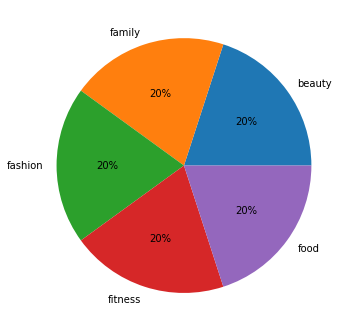

In [31]:
classes = list(count_dict.keys())
count = list(count_dict.values())

plt.figure(figsize=(5, 10))
plt.pie(count, labels=classes, autopct='%.f%%');

save_fig('Total Dataset Class Distribution')

In [32]:
def get_class_distribution_pie_chart(dataset, dataset_name):
    idx2class = {v: k for k, v in dataset.class_to_idx.items()}
    count_dict = {k:0 for k, v in dataset.class_to_idx.items()}
    
    for img, label_idx in dataset:
        label = idx2class[label_idx]
        count_dict[label] += 1
    
    classes = list(count_dict.keys())
    count = list(count_dict.values())
    
    plt.figure(figsize=(5, 10))
    plt.pie(count, labels=classes, autopct='%.f%%');
    save_fig(f'{dataset_name} Class Distribution')

Save Figure:  Train Dataset Class Distribution


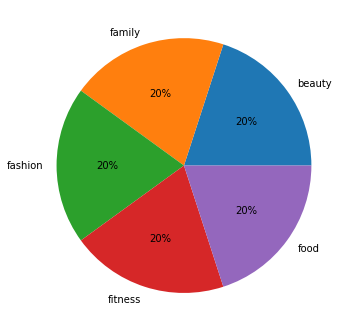

In [33]:
get_class_distribution_pie_chart(train_dataset, 'Train Dataset')

Save Figure:  Test Dataset Class Distribution


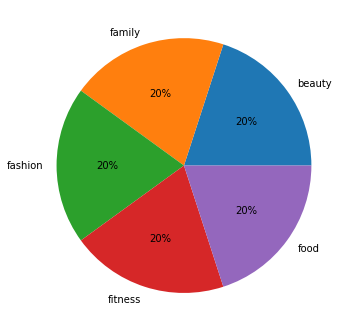

In [34]:
get_class_distribution_pie_chart(test_dataset, 'Test Dataset')

### Mini-Batch

In [85]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

train_iteration = len(train_loader)
test_iteration = len(test_loader)
print('Train Iteration : ', train_iteration); print('Test Iteration : ', test_iteration)

Train Iteration :  47
Test Iteration :  12


## 6. Check Data

In [69]:
for (X_train, y_train) in train_loader:
  print('X_train : ', X_train.size(), ' type : ', X_train.type())  # 64개의 RGB (channel 3개)로 이뤄진 224*224 이미지 데이터 [BATCH_SIZE, channel, height, width]
  print('y_train : ', y_train.size(), ' type : ', y_train.type())
  break

X_train :  torch.Size([256, 3, 224, 224])  type :  torch.FloatTensor
y_train :  torch.Size([256])  type :  torch.LongTensor


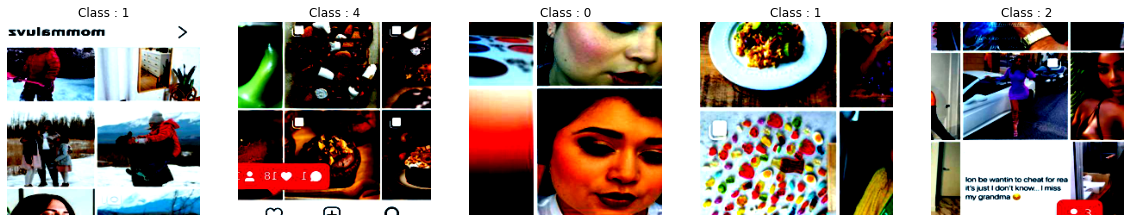

In [86]:
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0))) # [BATCH_SIZE, Channel, Height, Width]를 시각화하기 위해
    plt.title('Class : ' + str(y_train[i].item()))

## 7. Define Model - ResNet50

Total data가 3770장으로, 많은 편은 아니기 때문에 Transfer Learning 진행

![](https://blog.kakaocdn.net/dn/cjoceg/btq0ulXxaaM/dkAS3aQHHg6BU4ReLgxsFk/img.png)

ResNet-18,34은 Residual Block 사용
ResNet-50은 BottleNeck 사용

![](https://github.com/Pseudo-Lab/pytorch-guide/blob/main/img/03-1.png?raw=true)

According To [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [71]:
class BottleNeck(nn.Module):

    expansion = 4 # not out_planes, but expansion*out_planes =>  expansion factor for conv3
    
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes) # Prevent Internal Covariance Shift
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes) 
        self.conv3 = nn.Conv2d(out_planes, self.expansion*out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_planes)
        self.relu = nn.ReLU(inplace=True)
        
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*out_planes:
            conv = nn.Conv2d(in_planes, self.expansion*out_planes, kernel_size=1, stride=stride, bias=False)
            bn = nn.BatchNorm2d(self.expansion*out_planes)
            self.shortcut = nn.Sequential(conv, bn)
                
    def forward(self, x):
        
        # 1x1 convolution layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # 3x3 convolution layer
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        # 1x1 convolution layer
        x = self.conv3(x)
        x = self.bn3(x)
        
        x += self.shortcut(x)
        x = self.relu(x)

        return x

In [72]:
class ResNet(nn.Module):
    def __init__(self, block, n_blocks, channels, n_classes=num_of_classes):
        super(ResNet, self).__init__()
                
        self.in_planes = channels[0] 
            
        assert len(n_blocks) == len(channels) == 4 
        
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, n_blocks[0], channels[0])
        self.layer2 = self._make_layer(block, n_blocks[1], channels[1], stride=2)
        self.layer3 = self._make_layer(block, n_blocks[2], channels[2], stride=2)
        self.layer4 = self._make_layer(block, n_blocks[3], channels[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc = nn.Linear(self.in_planes, n_classes) # Fully Connected Layer
        
    def _make_layer(self, block, n_blocks, channels, stride=1):
        strides = [stride] + [1]*(n_blocks-1) # Block마다 stride 간격 설정
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, channels, stride))
            self.in_planes = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [73]:
resnet50_self = ResNet(block=BottleNeck, n_blocks=[3, 4, 6, 3], channels=[64, 128, 256, 512])

In [87]:
model_self = resnet50_self.to(DEVICE)
model_pytorch = models.resnet50().to(DEVICE)

In [88]:
# model_pytorch output 크기 설정
n_features = model_pytorch.fc.in_features
model_pytorch.fc = nn.Linear(n_features, num_of_classes)
model_pytorch = model_pytorch.to(DEVICE)

## 8. Optimizer / Objective Function / Learning rate Scheduler Setting

In [89]:
# Adam
optimizer_self = optim.Adam(model_self.parameters(), lr=learning_rate)
optimizer_pytorch = optim.Adam(model_pytorch.parameters(), lr=learning_rate)

# Objective Function
criterion = nn.CrossEntropyLoss()

#scheduler
ld = lambda epoch: 0.95 ** (epoch-8) if epoch >=8 else 1
scheduler_self = optim.lr_scheduler.LambdaLR(optimizer=optimizer_self,
                                        lr_lambda=ld,
                                        last_epoch=-1,
                                        verbose=False)

scheduler_pytorch = optim.lr_scheduler.LambdaLR(optimizer=optimizer_pytorch,
                                        lr_lambda=ld,
                                        last_epoch=-1,
                                        verbose=False)

print(model_pytorch)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 9. Training

In [90]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      optimizer.zero_grad()
      output=model(image)
      loss=criterion(output, label)
      loss.backward()
      optimizer.step()

      if batch_idx % log_interval == 0:
        print(f'Train Epoch : {Epoch} [{batch_idx * len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss : {loss.item():.3f} ')

    scheduler_pytorch.step()

In [91]:
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    success=0
    
    with torch.no_grad():
      for image, label in test_loader:
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        output=model(image)
        test_loss+=criterion(output, label).item()
        prediction=output.max(1, keepdim=True)[1]
        success+=prediction.eq(label.view_as(prediction)).sum().item()
            
      test_loss/=len(test_loader.dataset)
      test_accuracy=100*success/len(test_loader.dataset)
      return test_loss, test_accuracy

In [92]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [93]:
for Epoch in range(1, EPOCHS+1):
    train(model_pytorch, train_loader, optimizer_self, log_interval=10)
    test_loss, test_accuracy = evaluate(model_pytorch, test_loader)
    print(f'\n[EPOCH : {Epoch}], \tTest Loss : {test_loss:.3f}, \tTest Accurcy: {test_accuracy:.3f} %\n')

Train Epoch : 1 [0/3015(0%)]	Train Loss : 1.775 
Train Epoch : 1 [640/3015(21%)]	Train Loss : 1.889 
Train Epoch : 1 [1280/3015(43%)]	Train Loss : 1.721 
Train Epoch : 1 [1920/3015(64%)]	Train Loss : 1.729 
Train Epoch : 1 [2560/3015(85%)]	Train Loss : 1.756 

[EPOCH : 1], 	Test Loss : 0.027, 	Test Accurcy: 19.735 %

Train Epoch : 2 [0/3015(0%)]	Train Loss : 1.882 
Train Epoch : 2 [640/3015(21%)]	Train Loss : 1.676 
Train Epoch : 2 [1280/3015(43%)]	Train Loss : 1.778 
Train Epoch : 2 [1920/3015(64%)]	Train Loss : 1.778 
Train Epoch : 2 [2560/3015(85%)]	Train Loss : 1.777 

[EPOCH : 2], 	Test Loss : 0.028, 	Test Accurcy: 20.000 %

Train Epoch : 3 [0/3015(0%)]	Train Loss : 1.816 
Train Epoch : 3 [640/3015(21%)]	Train Loss : 1.952 
Train Epoch : 3 [1280/3015(43%)]	Train Loss : 1.818 
Train Epoch : 3 [1920/3015(64%)]	Train Loss : 1.646 
Train Epoch : 3 [2560/3015(85%)]	Train Loss : 1.768 

[EPOCH : 3], 	Test Loss : 0.028, 	Test Accurcy: 20.000 %

Train Epoch : 4 [0/3015(0%)]	Train Loss : 1